# Interpolación de Datos Cuánticos: \( N \) y \( g^{(2)}(0) \)

Este cuaderno explora distintas técnicas de **interpolación polinomial** aplicadas a datos generados mediante simulaciones cuánticas del estado estacionario de un sistema de cavidades acopladas a un emisor de dos niveles. El objetivo es obtener **representaciones continuas** y comparables de las magnitudes físicas claves:

- \( N = \langle a^\dagger a \rangle \): número promedio de fotones intracavidad
- \( g^{(2)}(0) \): función de correlación de segundo orden a tiempo cero

Para ello, se consideran únicamente un número reducido de puntos de la curva original, sobre los cuales se aplican los siguientes métodos de interpolación:

- **Interpolación de Lagrange**  
- **Método de Neville**  
- **Diferencias Divididas de Newton**  
- **Interpolación con Nodos Equiespaciados**  
- **Interpolación de Hermite**  

Estas técnicas permiten reconstruir la curva y estudiar su fidelidad comparada con los datos exactos. Las comparaciones visuales permiten evidenciar ventajas y limitaciones de cada enfoque.

---

## Bloqueo de Fotones

Un fenómeno clave observado en el sistema es el **bloqueo de fotones**, caracterizado por valores de \( g^{(2)}(0) < 1 \), indicando que la presencia de un fotón inhibe la entrada de otro. Esto se manifiesta típicamente en regímenes no lineales con fuerte acoplamiento y bajas poblaciones, y tiene aplicaciones relevantes en la generación de luz no clásica y el control de estados cuánticos de la luz.

---

## Parámetros físicos utilizados

Para todas las simulaciones se fijaron los siguientes parámetros:

- \( g = 1.1\kappa \): acoplamiento emisor–cavidad  
- \( J = 3\kappa \): acoplamiento entre cavidades  
- \( \kappa / 2\pi = 16 \) GHz: tasa de pérdida de la cavidad  
- \( \gamma / 2\pi = 1 \) GHz: tasa de decaimiento del emisor  
- \( \Delta = 0 \): sin desajuste de frecuencia

Las cantidades físicas se grafican como función de la intensidad de excitación \( E \), y se comparan con las distintas curvas interpoladas.

---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

plt.style.use("seaborn-v0_8-colorblind")


In [10]:
# Dimensiones de los modos
Ia = qeye(6)
Ib = qeye(6)
Is = qeye(2)

a = destroy(6)
b = destroy(6)
s = sigmap()

def Corre(D, g, J, Ea, Eb, theta):
    A = tensor(a, Ib, Is)
    
    H = (D * tensor(a.dag() * a, Ib, Is)
         + D * tensor(Ia, b.dag() * b, Is)
         + D * tensor(Ia, Ib, s.dag() * s)
         + g * (tensor(Ia, b, s.dag()) + tensor(Ia, b.dag(), s))
         + J * (tensor(a.dag(), b, Is) + tensor(a, b.dag(), Is))
         + Ea * tensor((a.dag() * np.exp(-1j * theta) + a * np.exp(1j * theta)), Ib, Is)
         + Eb * tensor(Ia, (b.dag() + b), Is))

    # Disipadores
    ops = [np.sqrt(kappa)*tensor(a, Ib, Is),
           np.sqrt(kappa)*tensor(Ia, b, Is),
           np.sqrt(gamma)*tensor(Ia, Ib, s)]

    rho_ss = steadystate(H, ops)
    
    n_ss = expect(tensor(a.dag() * a, Ib, Is), rho_ss)
    G2 = expect(tensor(a.dag() * a.dag() * a * a, Ib, Is), rho_ss)
    g2 = G2 / (n_ss ** 2) if n_ss > 0 else 0
    return (n_ss, g2)


In [23]:
# Parámetros físicos
kappa = 16 * np.pi
gamma = 1 * np.pi
D = 0
g = 1.1 * kappa
J = 3 * kappa
theta = 0
Eb = 0

# Barrido en Ea
Ea = np.linspace(0.001 * kappa, 3 * kappa, 100)
N = []
G2 = []

for i in Ea:
    val = Corre(D, g, J, i, Eb, theta)
    G2.append(val[1])
    N.append(val[0])

# Convertir a arrays
N = np.array(N)
G2 = np.array(G2)

# Selección de puntos para interpolación (por ejemplo, 10)
idx_sample = np.linspace(0, len(Ea) - 1, 10, dtype=int)
Ea_sample = Ea[idx_sample]
Ea_interp = np.linspace(Ea_sample[0], Ea_sample[-1], 300)
G2_sample = G2[idx_sample]
N_sample = N[idx_sample]


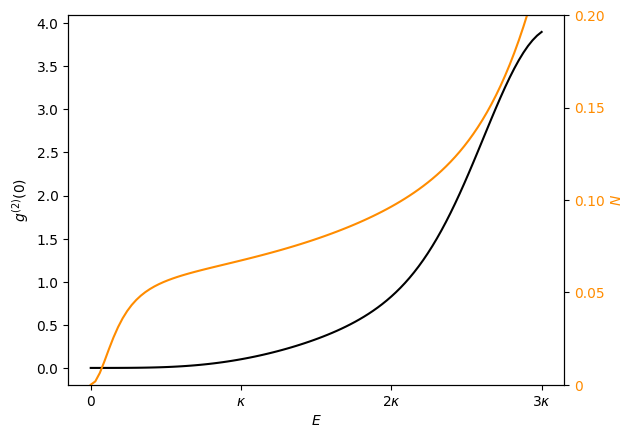

In [19]:
fig, ax1 = plt.subplots()
ax1.set_xlabel(r'$E$')
ax1.set_ylabel(r'$g^{(2)}(0)$', color='black')
ax1.plot(Ea, G2, 'k-', label=r'$g^{(2)}(0)$')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks([0, kappa, 2*kappa, 3*kappa], ['0', r'$\kappa$', r'2$\kappa$', r'3$\kappa$'])

ax2 = ax1.twinx()
ax2.set_ylabel(r'$N$', color='darkorange')
ax2.plot(Ea, N, color='darkorange', label=r'$N$')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_yticks([0, 0.05, 0.10, 0.15, 0.20], ['0', '0.05', '0.10', '0.15', '0.20'])

ax2.set_ylim(0, 0.20)
plt.show()

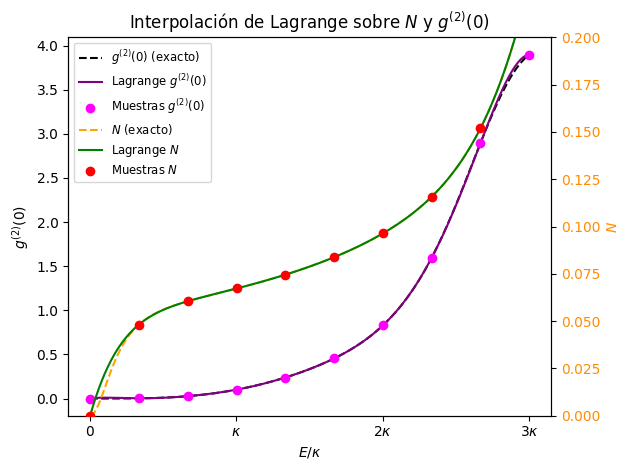

In [42]:
from moduloInterpolacion import polyInterpoLagrange, evalPoly, Neville, NodosEquiespaciados, Hermite
from sympy import symbols, lambdify

# Aplicar el método de Lagrange
coef_lagrange = polyInterpoLagrange((Ea_sample, N_sample))
coef_g2_lagrange = polyInterpoLagrange((Ea_sample, G2_sample))
# Evaluar el polinomio en malla fina
N_interp_lagrange = evalPoly(coef_lagrange, Ea_interp)
G2_interp_lagrange = evalPoly(coef_g2_lagrange, Ea_interp)

fig, ax1 = plt.subplots()

# g2(0): curva original + interpolada
ax1.set_xlabel(r'$E/\kappa$')
ax1.set_ylabel(r'$g^{(2)}(0)$', color='black')
l1, = ax1.plot(Ea / kappa, G2, 'k--', label=r'$g^{(2)}(0)$ (exacto)')
l2, = ax1.plot(Ea_interp / kappa, G2_interp_lagrange, color='purple', label='Lagrange $g^{(2)}(0)$')
l3 = ax1.scatter(Ea_sample / kappa, G2_sample, color='magenta', zorder=5, label='Muestras $g^{(2)}(0)$')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks([0, 1, 2, 3], ['0', r'$\kappa$', r'$2\kappa$', r'$3\kappa$'])

# N: curva original + interpolada
ax2 = ax1.twinx()
ax2.set_ylabel(r'$N$', color='darkorange')
l4, = ax2.plot(Ea / kappa, N, color='orange', linestyle='--', label=r'$N$ (exacto)')
l5, = ax2.plot(Ea_interp / kappa, N_interp_lagrange, color='green', label='Lagrange $N$')
l6 = ax2.scatter(Ea_sample / kappa, N_sample, color='red', zorder=5, label='Muestras $N$')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim(0, 0.20)

# Leyenda conjunta (agrupa todos los objetos)
handles = [l1, l2, l3, l4, l5, l6]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left', fontsize='small', frameon=True)

plt.title("Interpolación de Lagrange sobre $N$ y $g^{(2)}(0)$")
plt.tight_layout()
plt.show()


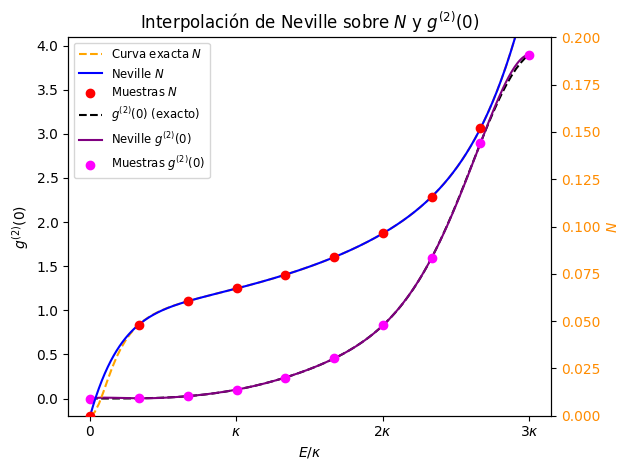

In [44]:
x = symbols('x')

# --- Neville para N ---
neville_mat_N, _ = Neville((Ea_sample, N_sample))
P_neville_N = None
for poly in reversed(neville_mat_N.flatten()):
    if poly != 0 and hasattr(poly, 'free_symbols') and x in poly.free_symbols:
        P_neville_N = poly
        break

if P_neville_N is None:
    raise ValueError("No se encontró un polinomio válido para N en la matriz de Neville.")

P_neville_func_N = lambdify(x, P_neville_N, modules='numpy')
N_interp_neville = np.array([P_neville_func_N(xi) for xi in Ea_interp])

# --- Neville para g²(0) ---
G2_sample = G2[idx_sample]
neville_mat_G2, _ = Neville((Ea_sample, G2_sample))
P_neville_G2 = None
for poly in reversed(neville_mat_G2.flatten()):
    if poly != 0 and hasattr(poly, 'free_symbols') and x in poly.free_symbols:
        P_neville_G2 = poly
        break

if P_neville_G2 is None:
    raise ValueError("No se encontró un polinomio válido para g²(0) en la matriz de Neville.")

P_neville_func_G2 = lambdify(x, P_neville_G2, modules='numpy')
G2_interp_neville = np.array([P_neville_func_G2(xi) for xi in Ea_interp])

# --- Gráfica combinada ---
fig, ax1 = plt.subplots()

# g²(0): exacta + Neville
ax1.set_xlabel(r'$E/\kappa$')
ax1.set_ylabel(r'$g^{(2)}(0)$', color='black')
l4, = ax1.plot(Ea / kappa, G2, 'k--', label=r'$g^{(2)}(0)$ (exacto)')
l5, = ax1.plot(Ea_interp / kappa, G2_interp_neville, color='purple', label='Neville $g^{(2)}(0)$')
l6 = ax1.scatter(Ea_sample / kappa, G2_sample, color='magenta', label='Muestras $g^{(2)}(0)$', zorder=5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks([0, 1, 2, 3], ['0', r'$\kappa$', r'$2\kappa$', r'$3\kappa$'])

# N: exacta + Neville
ax2 = ax1.twinx()
ax2.set_ylabel(r'$N$', color='darkorange')
l1, = ax2.plot(Ea / kappa, N, linestyle='--', color='orange', label='Curva exacta $N$')
l2, = ax2.plot(Ea_interp / kappa, N_interp_neville, color='blue', label='Neville $N$')
l3 = ax2.scatter(Ea_sample / kappa, N_sample, color='red', label='Muestras $N$', zorder=5)
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim(0, 0.20)

# Leyenda unificada
handles = [l1, l2, l3, l4, l5, l6]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left', fontsize='small', frameon=True)

plt.title("Interpolación de Neville sobre $N$ y $g^{(2)}(0)$")
plt.tight_layout()
plt.show()

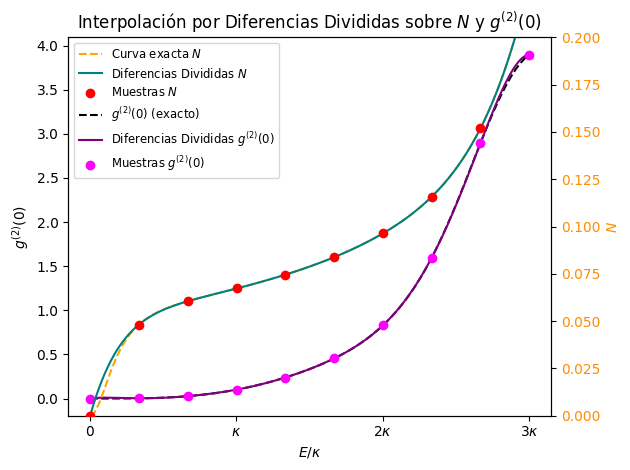

In [45]:
# Diferencias Divididas para N
poly_dic_dd_N = DiferenciasDivididas((Ea_sample, N_sample))
P_dd_N = poly_dic_dd_N[f'P{len(Ea_sample)-1}']
N_interp_dd = evalPoly(P_dd_N, Ea_interp)

# Diferencias Divididas para g²(0)
G2_sample = G2[idx_sample]
poly_dic_dd_G2 = DiferenciasDivididas((Ea_sample, G2_sample))
P_dd_G2 = poly_dic_dd_G2[f'P{len(Ea_sample)-1}']
G2_interp_dd = evalPoly(P_dd_G2, Ea_interp)

# Graficar ambos en la misma figura
fig, ax1 = plt.subplots()

# g²(0): curva exacta + interpolación
ax1.set_xlabel(r'$E/\kappa$')
ax1.set_ylabel(r'$g^{(2)}(0)$', color='black')
l4, = ax1.plot(Ea / kappa, G2, 'k--', label=r'$g^{(2)}(0)$ (exacto)')
l5, = ax1.plot(Ea_interp / kappa, G2_interp_dd, color='purple', label='Diferencias Divididas $g^{(2)}(0)$')
l6 = ax1.scatter(Ea_sample / kappa, G2_sample, color='magenta', label='Muestras $g^{(2)}(0)$', zorder=5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks([0, 1, 2, 3], ['0', r'$\kappa$', r'$2\kappa$', r'$3\kappa$'])

# N: curva exacta + interpolación
ax2 = ax1.twinx()
ax2.set_ylabel(r'$N$', color='darkorange')
l1, = ax2.plot(Ea / kappa, N, linestyle='--', color='orange', label='Curva exacta $N$')
l2, = ax2.plot(Ea_interp / kappa, N_interp_dd, color='teal', label='Diferencias Divididas $N$')
l3 = ax2.scatter(Ea_sample / kappa, N_sample, color='red', label='Muestras $N$', zorder=5)
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim(0, 0.20)

# Leyenda unificada
handles = [l1, l2, l3, l4, l5, l6]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left', fontsize='small', frameon=True)

plt.title("Interpolación por Diferencias Divididas sobre $N$ y $g^{(2)}(0)$")
plt.tight_layout()
plt.show()

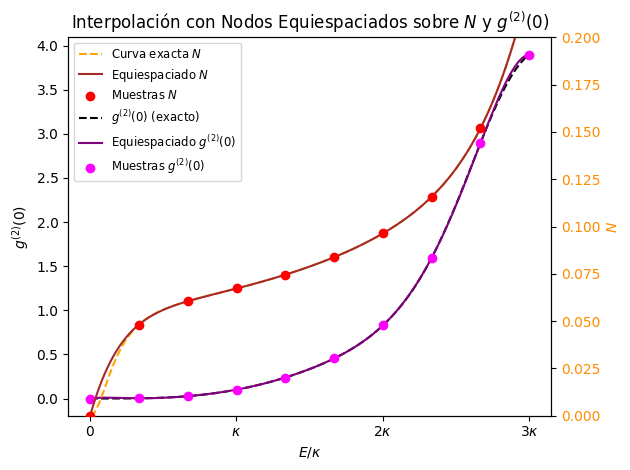

In [ ]:
x_0 = Ea_sample[0]
h = Ea_sample[1] - Ea_sample[0]

# Aplicar nodos equiespaciados al conjunto de N
poly_dic_eq_N = NodosEquiespaciados(N_sample, x_0, h)
P_eq_N = poly_dic_eq_N[f'P{len(N_sample)-1}']

# Interpolación para g²(0)
poly_dic_eq_G2 = NodosEquiespaciados(G2_sample, x_0, h)
P_eq_G2 = poly_dic_eq_G2[f'P{len(G2_sample)-1}']

# Evaluar el polinomio en la malla fina
N_interp_eq = evalPoly(P_eq_N, Ea_interp)
G2_interp_eq = evalPoly(P_eq_G2, Ea_interp)

fig, ax1 = plt.subplots()

# g²(0): exacto + interpolado
ax1.set_xlabel(r'$E/\kappa$')
ax1.set_ylabel(r'$g^{(2)}(0)$', color='black')
l4, = ax1.plot(Ea / kappa, G2, 'k--', label=r'$g^{(2)}(0)$ (exacto)')
l5, = ax1.plot(Ea_interp / kappa, G2_interp_eq, color='purple', label='Equiespaciado $g^{(2)}(0)$')
l6 = ax1.scatter(Ea_sample / kappa, G2_sample, color='magenta', label='Muestras $g^{(2)}(0)$', zorder=5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks([0, 1, 2, 3], ['0', r'$\kappa$', r'$2\kappa$', r'$3\kappa$'])

# N: exacto + interpolado
ax2 = ax1.twinx()
ax2.set_ylabel(r'$N$', color='darkorange')
l1, = ax2.plot(Ea / kappa, N, linestyle='--', color='orange', label='Curva exacta $N$')
l2, = ax2.plot(Ea_interp / kappa, N_interp_eq, color='brown', label='Equiespaciado $N$')
l3 = ax2.scatter(Ea_sample / kappa, N_sample, color='red', label='Muestras $N$', zorder=5)
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim(0, 0.20)

# Leyenda combinada
handles = [l1, l2, l3, l4, l5, l6]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left', fontsize='small', frameon=True)

plt.title("Interpolación con Nodos Equiespaciados sobre $N$ y $g^{(2)}(0)$")
plt.tight_layout()
plt.show()

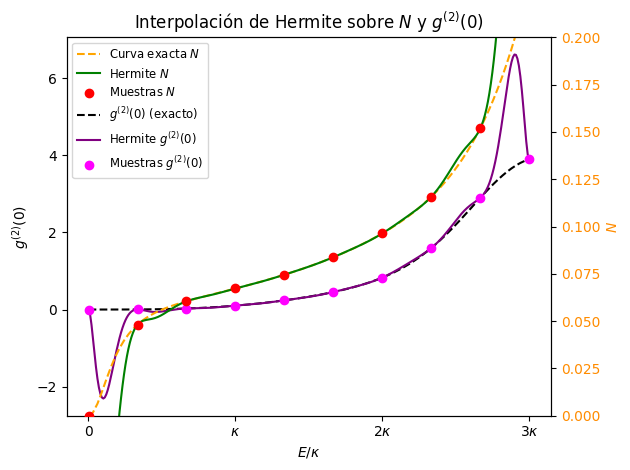

In [49]:
# Derivadas aproximadas para N y G2 en los nodos muestreados
dN_sample = np.gradient(N_sample, Ea_sample)
dG2_sample = np.gradient(G2_sample, Ea_sample)

# dN_sample[0] = dN_sample[-1] = 0
# dG2_sample[0] = dG2_sample[-1] = 0

# Aplicar interpolación de Hermite a N
coef_hermite_N = Hermite((Ea_sample, N_sample, dN_sample))
N_interp_hermite = evalPoly(coef_hermite_N, Ea_interp)

# Aplicar interpolación de Hermite a G2
coef_hermite_G2 = Hermite((Ea_sample, G2_sample, dG2_sample))
G2_interp_hermite = evalPoly(coef_hermite_G2, Ea_interp)

fig, ax1 = plt.subplots()

# g²(0): exacto + Hermite
ax1.set_xlabel(r'$E/\kappa$')
ax1.set_ylabel(r'$g^{(2)}(0)$', color='black')
l4, = ax1.plot(Ea / kappa, G2, 'k--', label=r'$g^{(2)}(0)$ (exacto)')
l5, = ax1.plot(Ea_interp / kappa, G2_interp_hermite, color='purple', label='Hermite $g^{(2)}(0)$')
l6 = ax1.scatter(Ea_sample / kappa, G2_sample, color='magenta', label='Muestras $g^{(2)}(0)$', zorder=5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks([0, 1, 2, 3], ['0', r'$\kappa$', r'$2\kappa$', r'$3\kappa$'])

# N: exacto + Hermite
ax2 = ax1.twinx()
ax2.set_ylabel(r'$N$', color='darkorange')
l1, = ax2.plot(Ea / kappa, N, linestyle='--', color='orange', label='Curva exacta $N$')
l2, = ax2.plot(Ea_interp / kappa, N_interp_hermite, color='green', label='Hermite $N$')
l3 = ax2.scatter(Ea_sample / kappa, N_sample, color='red', label='Muestras $N$', zorder=5)
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim(0, 0.20)

# Leyenda conjunta
handles = [l1, l2, l3, l4, l5, l6]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper left', fontsize='small', frameon=True)

plt.title("Interpolación de Hermite sobre $N$ y $g^{(2)}(0)$")
plt.tight_layout()
plt.show()